In [22]:
import warnings
from utils.plotting_helpers import plot_weights
from environements.portfolio_optimization_env_flat import PortfolioOptimizationEnvFlat
import matplotlib as mpl
from utils.portfolio_trainer import PortfolioOptimization
from pandas import read_csv
from utils.feature_engineer import FeatureEngineer
from utils.helpers import data_split
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import scienceplots
from utils.plotting_helpers import plot_mvo_weights
import utils.mean_variance_optimization as mvo
df_dow = read_csv('./data/dow.csv')
# mpl.rcParams['figure.dpi'] = 300

df_nasdaq = read_csv('./data/nasdaq.csv')
df_hsi = read_csv('./data/hsi.csv')
df_dax = read_csv('./data/dax.csv')
df_sp500 = read_csv('./data/sp500.csv')
warnings.filterwarnings("ignore")


def linear_schedule(initial_value):
    def scheduler(progress_remaining):
        return initial_value * progress_remaining
    return scheduler

In [2]:
df = df_dow.copy()
df = df_dow[df_dow.tic.isin([ 'AXP', 'DIS', 'GS', 'MMM', 'WBA'])]
TRAIN_START_DATE = '2015-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2022-01-01'
INDICATORS = [
    "close_21_ema",
    "close_62_ema"
]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list=INDICATORS,
                     use_turbulence=False,
                     user_defined_feature=True)

processed_dax = fe.preprocess_data(df.query('date>"2014-01-01"'))
cleaned_data = processed_dax.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf, 0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 5


In [3]:
def add_volatility(df, periods=21):
    rolling_volatility = df.groupby(
        'tic')['log_return'].rolling(window=periods).std()
    rolling_volatility = rolling_volatility.reset_index(level=0, drop=True)
    # Assign the annualized volatility back to the original DataFrame
    df['volatility'] = rolling_volatility

    # Fill missing values with 0 (first periods will have NaN)
    df['volatility'].fillna(0, inplace=True)

    return df


cleaned_data = add_volatility(cleaned_data)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Stock Dimension: 5


In [5]:
cleaned_data

,Unnamed: 0,date,open,high,low,close,volume,tic,day,close_21_ema,close_62_ema,return,log_return,volatility
0,164790,2014-01-02,90.900002,91.080002,89.379997,76.407570,5112000,AXP,3,76.407570,76.407570,0.003242,0.003237,0.000000
2704,164796,2014-01-02,76.040001,76.500000,75.900002,69.643188,5200900,DIS,3,69.643188,69.643188,0.003242,0.003237,0.000000
5408,164797,2014-01-02,176.949997,178.380005,176.360001,144.011459,1982100,GS,3,144.011459,144.011459,0.003242,0.003237,0.000000
8112,164806,2014-01-02,115.426422,116.220734,115.058525,80.494003,3650312,MMM,3,80.494003,80.494003,0.003242,0.003237,0.000000
10816,164815,2014-01-02,57.200001,57.250000,56.520000,37.836075,5370600,WBA,3,37.836075,37.836075,0.003242,0.003237,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2703,244569,2024-09-30,270.100006,271.480011,267.290009,270.493195,2113100,AXP,0,261.151739,250.436479,0.000517,0.000516,0.016371
5407,244575,2024-09-30,96.849998,97.570000,95.440002,96.190002,7982300,DIS,0,92.614401,93.250887,0.001875,0.001873,0.007896
8111,244577,2024-09-30,494.890015,496.519989,488.899994,495.109985,1602500,GS,0,491.928366,482.926628,-0.006820,-0.006844,0.019018
10815,244586,2024-09-30,137.830002,137.949997,135.229996,135.976822,3814000,MMM,0,132.985017,123.499500,-0.004370,-0.004380,0.012471


begin_total_asset:50000
end_total_asset:41716.41038950245
Sharpe:  -0.34198359952240126
Test Finished!
episode_return 0.834328207790049


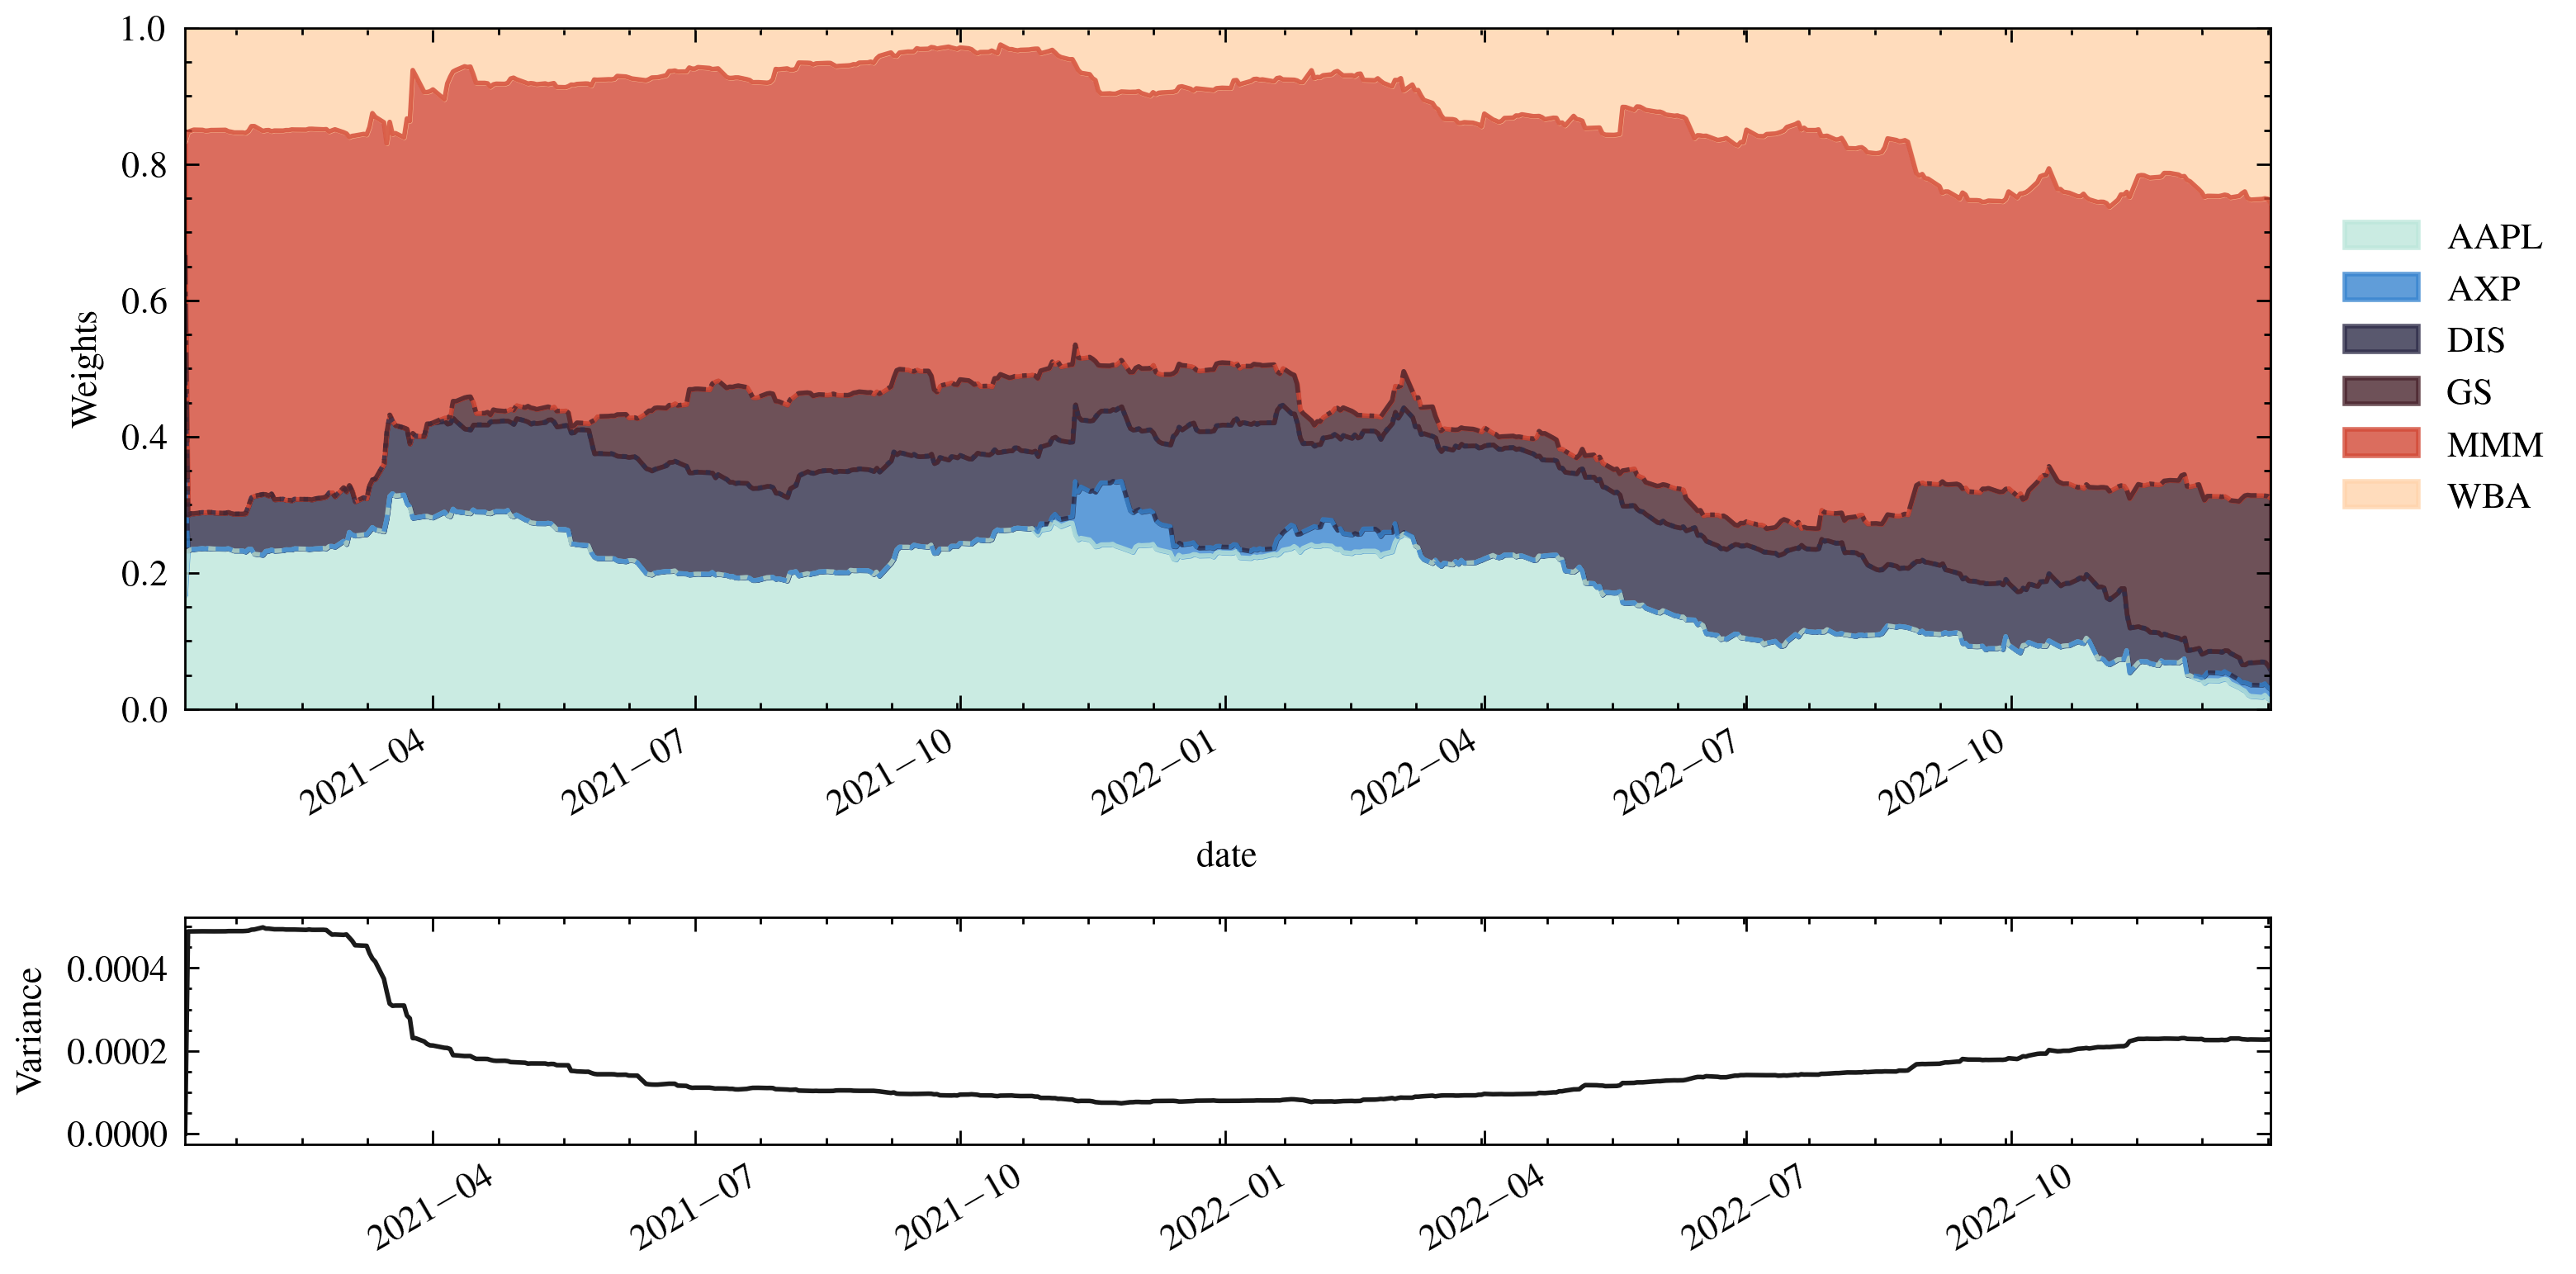

In [7]:
from utils.mean_variance_optimization import mvo_data
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2023-01-01'
covariances = mvo_data(cleaned_data,[],TEST_START_DATE,TEST_END_DATE)
res = mvo.mean_variance_optimization(covariances,pct=0)
%matplotlib inline
plot_mvo_weights(res,test_data,dpi=400,figsize=(8,4),save_path = 'mvo_detail.png')

PPO WITHOUT WEIGHT

Use normalization

In [ ]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(seed=seed,
    transaction_fee=0,comission_fee_model=None,remove_close=True, tag="ppo_5days"
    , sharp_reward=False, last_weight=False, add_cash=False,env = PortfolioOptimizationEnvFlat)
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","volatility"],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 32,'learning_rate':linear_schedule(1e-4),'gamma':0.95,'gae_lambda':0.95},
#                         window_size=5,
#                         iterations=400_000)
test_env = optimizer.create_environment(test_data,["close", "log_return", "volatility"],21)
test_result = optimizer.load_from_file(
    'ppo',test_env, cwd="data\ppo_close_log_return_volatility_window_size_21_0_ppo_5days\ppo_200000_steps",deterministic=True)


Successfully load model data\ppo_close_log_return_volatility_window_size_21_0_ppo_5days\ppo_200000_steps
Initial portfolio value:250000
Final portfolio value: 316025.625
Final accumulative portfolio value: 1.2641024589538574
Maximum DrawDown: -0.16641413284769846
Sharpe ratio: 1.156670337675654


Struggles with rew

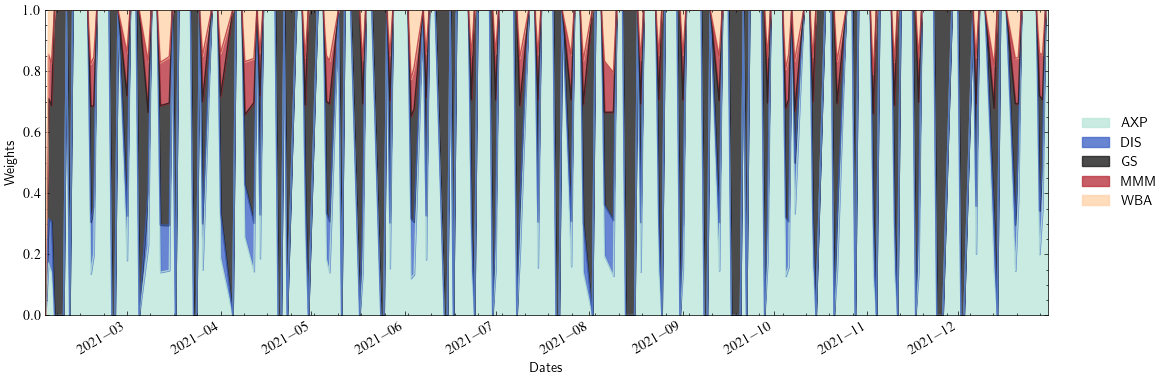

In [6]:
from utils.plotting_helpers import plot_weights
plot_weights(test_result[0].weights, test_result[0].date, test_result[1],add_cash=False)

SP 500


In [2]:
df_sp500 = read_csv('./data/sp500.csv')
df = df_sp500[df_sp500.tic.isin(
    ['PG', 'BA', 'NKE', 'JPM', 'MCD', 'TRV', 'UNH', 'SHW', 'VZ'])]
TRAIN_START_DATE = '2015-01-01'
TRAIN_END_DATE = '2019-12-30'

VALIDATION_START_DATE = '2020-01-01'
VALIDATION_END_DATE = '2020-12-30'

TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2023-01-01'
INDICATORS = [
    "close_21_ema",
    "close_62_ema"
]

fe = FeatureEngineer(use_technical_indicator=True,
                     tech_indicator_list=INDICATORS,
                     use_turbulence=False,
                     user_defined_feature=True)

processed_dax = fe.preprocess_data(df.query('date>"2014-01-01"'))
cleaned_data = processed_dax.copy()
cleaned_data = cleaned_data.fillna(0)
cleaned_data = cleaned_data.replace(np.inf, 0)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")


def add_volatility(df, periods=21):
    rolling_volatility = df.groupby(
        'tic')['log_return'].rolling(window=periods).std()
    rolling_volatility = rolling_volatility.reset_index(level=0, drop=True)
    # Assign the annualized volatility back to the original DataFrame
    df['volatility'] = rolling_volatility

    # Fill missing values with 0 (first periods will have NaN)
    df['volatility'].fillna(0, inplace=True)

    return df


cleaned_data = add_volatility(cleaned_data)
train_data = data_split(cleaned_data, TRAIN_START_DATE, TRAIN_END_DATE)
test_data = data_split(cleaned_data, TEST_START_DATE, TEST_END_DATE)
validation_data = data_split(
    cleaned_data, VALIDATION_START_DATE, VALIDATION_END_DATE)
stock_dimension = len(train_data.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}")

Successfully added technical indicators
Successfully added user defined features
Stock Dimension: 9
Stock Dimension: 9


In [9]:
%matplotlib inline

import torch
from environements.portfolio_optimization_env import PortfolioOptimizationEnv
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

optimizer = PortfolioOptimization(seed=seed,
    transaction_fee=0,comission_fee_model=None,remove_close=True, tag="ppo_5days"
    , sharp_reward=False, last_weight=False, add_cash=False,env = PortfolioOptimizationEnvFlat)
# optimizer.train_model(train_data,
#                         validation_data,
#                         features=["close", "log_return","volatility"],
#                         model_name="ppo",
#                         args={"n_steps":  256, "batch_size": 32,'learning_rate':linear_schedule(1e-4),'gamma':0.95,'gae_lambda':0.95},
#                         window_size=5,
#                         iterations=400_000)
test_env = optimizer.create_environment(test_data,["close", "log_return", "volatility"],21)
test_result = optimizer.load_from_file(
    'ppo',test_env, cwd="data\ppo_close_log_return_volatility_window_size_21_0.005_ppo_21_sp500\ppo_260000_steps",deterministic=True)


Successfully load model data\ppo_close_log_return_volatility_window_size_21_0.005_ppo_21_sp500\ppo_260000_steps
Initial portfolio value:250000
Final portfolio value: 281731.5
Final accumulative portfolio value: 1.1269259452819824
Maximum DrawDown: -0.2934534679705165
Sharpe ratio: 0.4198697924010048


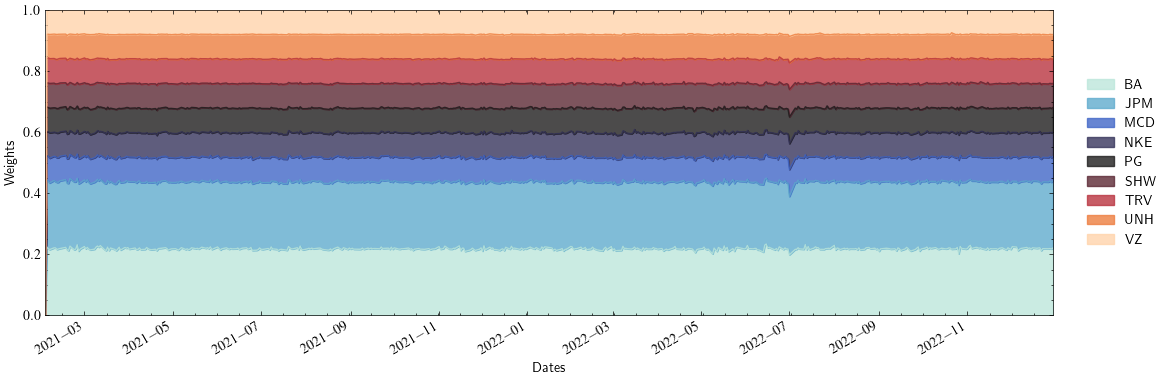

In [10]:
from utils.plotting_helpers import plot_weights
plot_weights(test_result[0].weights, test_result[0].date, test_result[1].copy(),add_cash=False)


In [11]:
from utils.mean_variance_optimization import mvo_data
TEST_START_DATE = '2021-01-01'
TEST_END_DATE = '2023-01-01'
covariances = mvo_data(cleaned_data,[],TEST_START_DATE,TEST_END_DATE)
res = mvo.mean_variance_optimization(covariances,pct=0)


begin_total_asset:50000
end_total_asset:50078.35360491759
Sharpe:  0.0788604344278655
Test Finished!
episode_return 1.0015670720983518


In [21]:
res_sharpe = mvo.mean_variance_optimization(covariances,pct=0,objective='sharpe')


KeyboardInterrupt: 

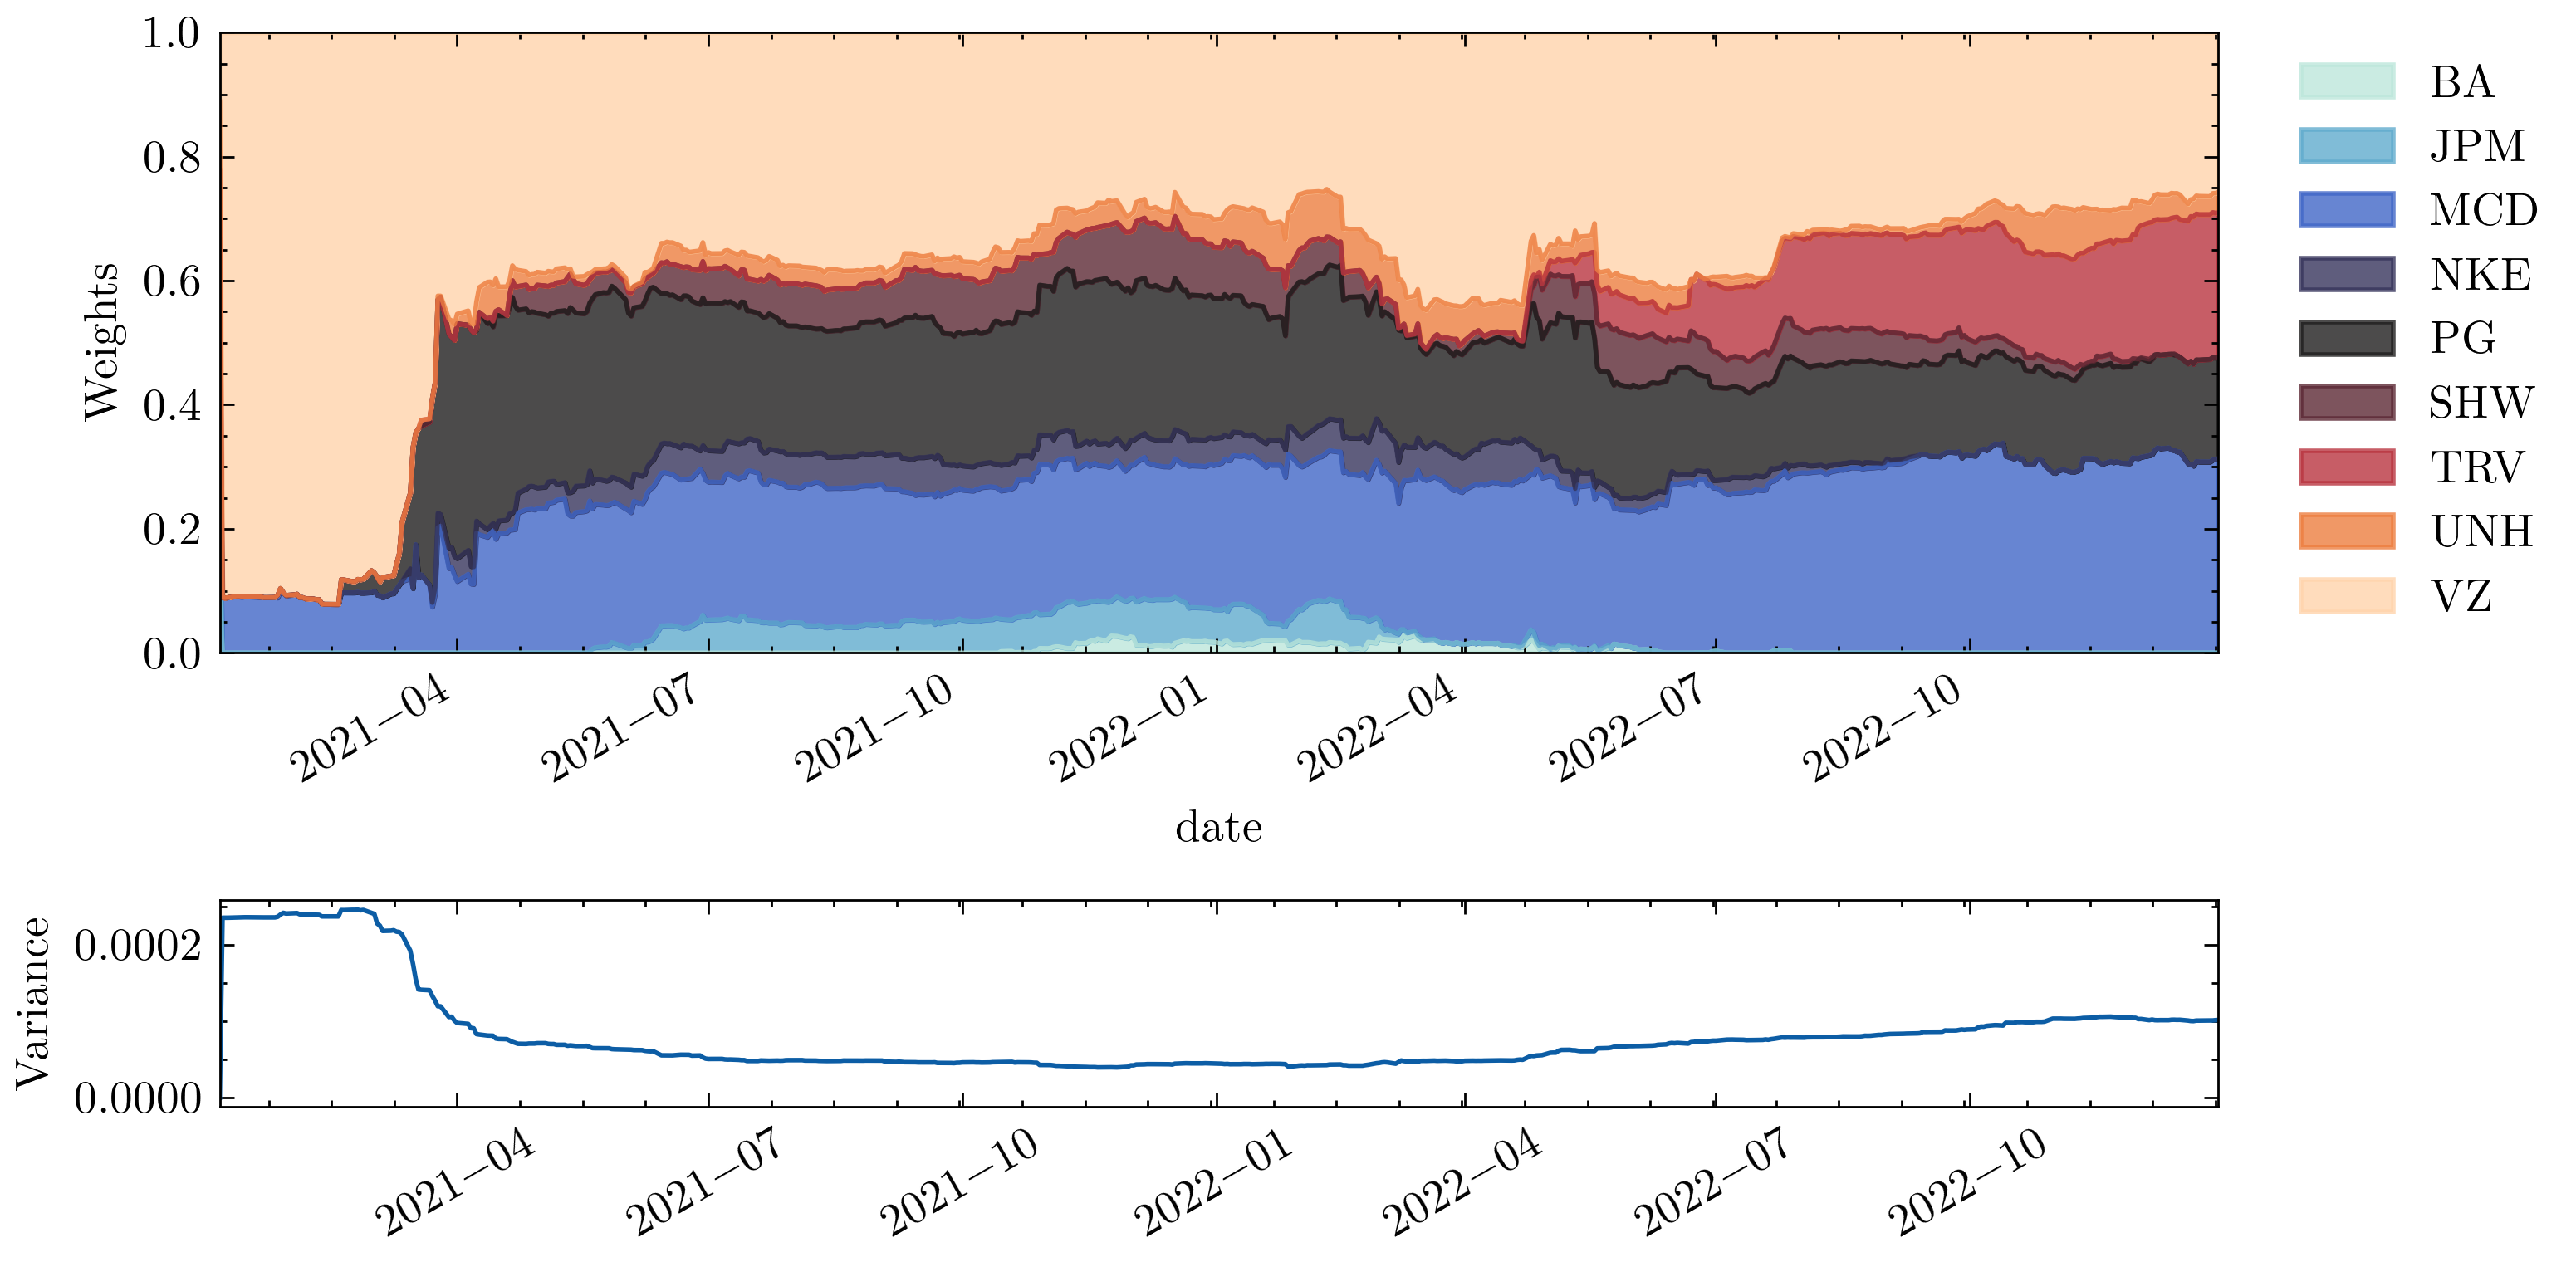

In [12]:
%matplotlib inline
plot_mvo_weights(res,test_data,dpi=400,figsize=(8,4),save_path = 'mvo_detail.png')

In [17]:
from environements.portfolio_optimization_env import PortfolioOptimizationEnv


stock_dimension = len(test_data.tic.unique())
environment_train_buy_and_hold_sp500 = PortfolioOptimizationEnv(
    test_data,
    initial_amount=1000000,
    comission_fee_pct=0,
    time_window=5,
    features = ["close","return"],
    normalize_df=None,
    add_cash=False
)
terminated = False

environment_train_buy_and_hold_sp500.reset()

while not terminated:
    action = [1/stock_dimension] * stock_dimension
    _, _, terminated,_, _ = environment_train_buy_and_hold_sp500.step(
        np.array(action, dtype=np.float32))

Initial portfolio value:1000000
Final portfolio value: 1110323.125
Final accumulative portfolio value: 1.1103230714797974
Maximum DrawDown: -0.25628666989260196
Sharpe ratio: 0.39926758582902966


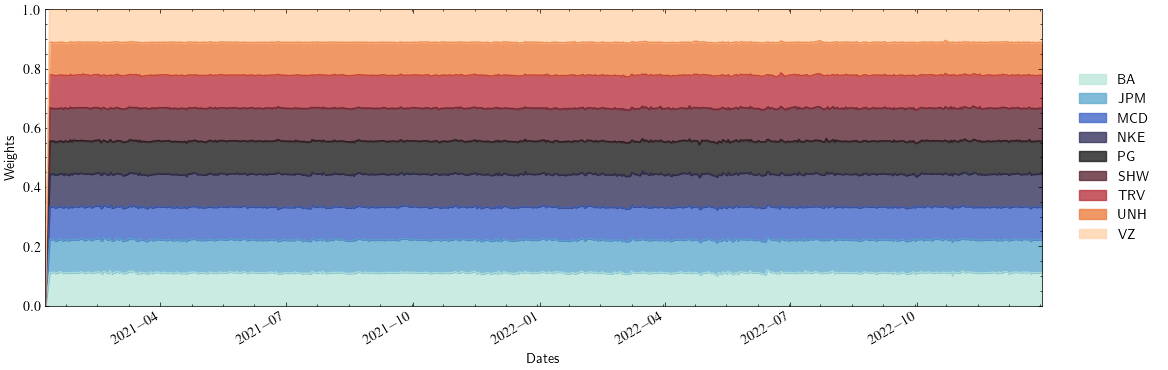

In [18]:
from utils.plotting_helpers import plot_buy_and_hold_weights

plot_buy_and_hold_weights(environment_train_buy_and_hold_sp500,test_data=test_data,ad_cash=False)

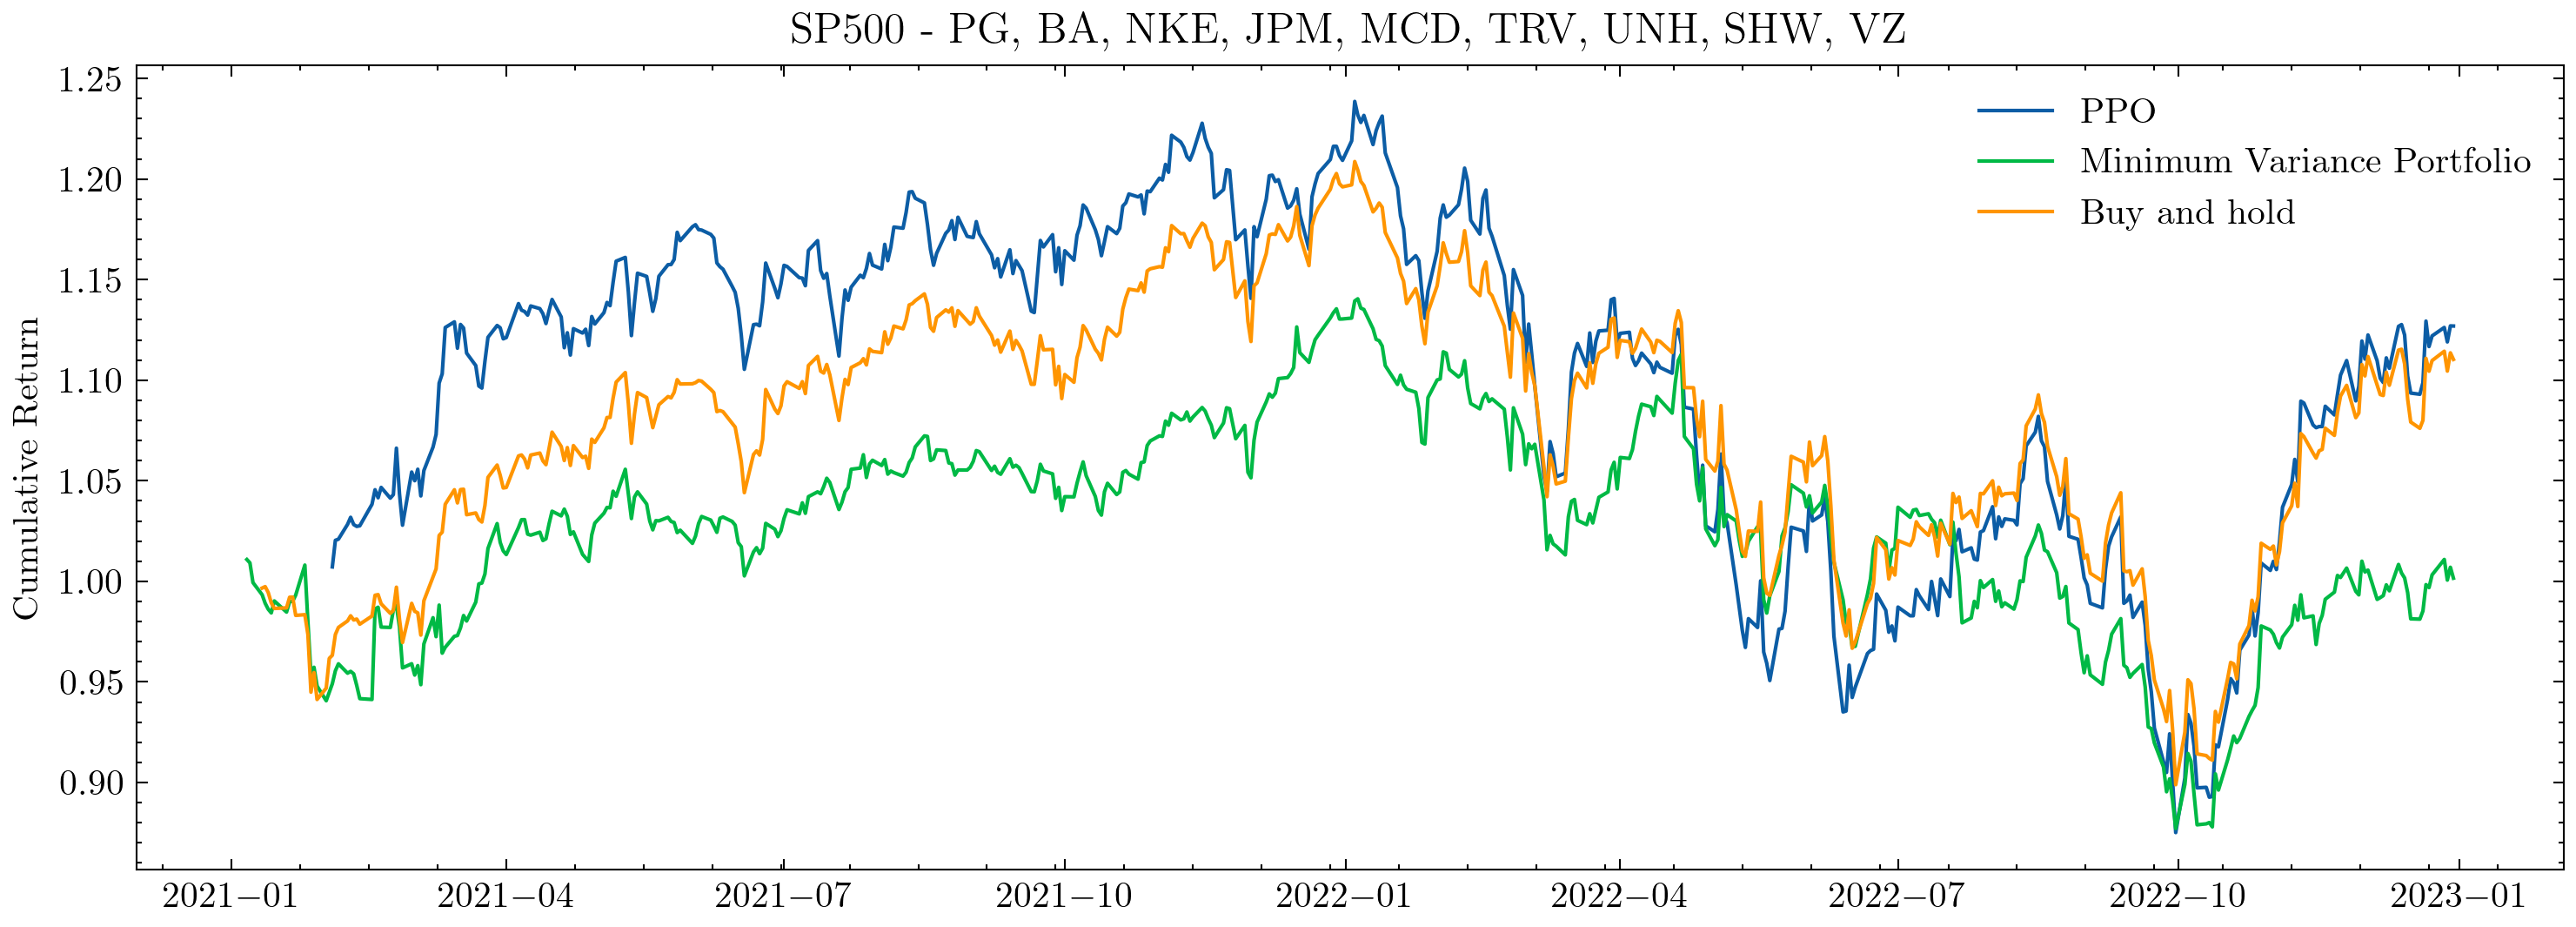

In [20]:
import matplotlib.pyplot as plt
import scienceplots
plt.rcdefaults()
%matplotlib inline
with plt.style.context('science', 'ieee'):
    plt.figure(figsize=(12,4),dpi=300)
    plt.plot(test_result[0].get('date'),(test_result[0]['account'].pct_change() +1).cumprod(),label='PPO')
    plt.plot(res['test'].date,(res['test'].total_assets.pct_change() + 1).cumprod(),label='Minimum Variance Portfolio')
    plt.plot(environment_train_buy_and_hold_sp500._date_memory,(pd.Series(environment_train_buy_and_hold_sp500._asset_memory["final"]).pct_change() + 1).cumprod(),label='Buy and hold')
    plt.legend()
    plt.ylabel('Cumulative Return')
    plt.title('SP500 - PG, BA, NKE, JPM, MCD, TRV, UNH, SHW, VZ')
    plt.savefig('dow_comparison.png', dpi=500)
    plt.show()

In [24]:
df_sp500 = read_csv('./data/sp500.csv')
df = df_sp500[df_sp500.tic.isin(
    ['PG', 'BA', 'NKE', 'JPM', 'MCD', 'TRV', 'UNH', 'SHW', 'VZ'])]
df.to_csv('./datasets/sp500.csv')